In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import time

from utils.plot_utils import regression_plot_with_uncertainty
from utils.Prediction_bands import split_conformal_bands, weighted_conformal_prediction

from concurrent.futures import ThreadPoolExecutor
from scipy.stats import multivariate_normal, norm


In [55]:
path = "/Users/igor.ap/Downloads/Thesis files/Code/THESIS/Data/electricity-normalized.csv"
data = pd.read_csv(path, sep = ",")

In [56]:
data

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0000,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP
1,0.0000,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP
2,0.0000,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP
3,0.0000,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP
4,0.0000,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN
...,...,...,...,...,...,...,...,...,...
45307,0.9158,7,0.914894,0.044224,0.340672,0.003033,0.255049,0.405263,DOWN
45308,0.9158,7,0.936170,0.044884,0.355549,0.003072,0.241326,0.420614,DOWN
45309,0.9158,7,0.957447,0.043593,0.340970,0.002983,0.247799,0.362281,DOWN
45310,0.9158,7,0.978723,0.066651,0.329366,0.004630,0.345417,0.206579,UP


In [57]:
check_data = data.copy()    
check_data = check_data.drop(columns = ["date", "day", "class"])

In [58]:
import pyperclip
check_data.describe()
latex_table = check_data.describe().to_latex()

# Copy the LaTeX table to the clipboard
pyperclip.copy(latex_table)


In [109]:
def run(X_, Y_, alpha, prediction_interval, methods, indexing=None):

    rho = rho_LS = 0.99 
    X = X_
    Y = Y_
    N = X.shape[0]
    train_lag = 600
    PI_split_CP = prediction_interval
    
    
    def predict(pred_idx):
        time.sleep(0.1)

        for method_idx, method in enumerate(methods):
            if method in ['nexCP+LS', 'nexCP+WLS']:
                weights = rho**(np.arange(pred_idx, 0, -1))
                weights = np.r_[weights, 1]
            
            elif method == "gaussian":
                
                #Select one 
                
                # h = 1.5
                # h = 1.06 * np.std(Y[:pred_idx], ddof=1) * (pred_idx + 1)**(-1/5)
                
                
                
                X_train_normalised = (X[:pred_idx + 1] - np.mean(X[:pred_idx + 1])) / np.std(X[:pred_idx])
                
                
                X_tilde = multivariate_normal.rvs(mean=X_train_normalised[pred_idx], cov=np.diag(np.ones(4)) * h**2)
                weights = np.exp(-0.5 * np.linalg.norm((X_train_normalised[:pred_idx + 1] - X_tilde), axis=1)**2 / h**2)
                weights = np.r_[weights, 1]
                
            else:
                weights = np.ones(pred_idx + 1)
            
            if method == 'nexCP+WLS':
                tags = rho_LS**(np.arange(pred_idx, -1, -1))
            elif method == 'gaussian':
                tags = weights[:-1]
                
            else:
                tags = np.ones(pred_idx + 1)
                
            if indexing == "odd":
                inds_odd = np.arange(1, int(np.ceil(pred_idx / 2) * 2 - 1), 2)
                inds_even = np.arange(2, int(np.floor(pred_idx / 2) * 2), 2)

         

                predictor = LinearRegression()
                predictor.fit(X[inds_odd], Y[inds_odd], tags[inds_odd])

                mean_prediction, prediction_bands, quantile, weights_normalised = weighted_conformal_prediction(
                    predictor,
                    X[inds_even],
                    Y[inds_even],
                    X[pred_idx][np.newaxis, :],
                    weights[inds_even],
                    alpha
                )
                PI_split_CP[method_idx, pred_idx, :] = prediction_bands
            
            else:
                inds_all = np.arange(pred_idx)

              
                predictor = LinearRegression()
                predictor.fit(X[inds_all], Y[inds_all], sample_weight=tags[inds_all])

                mean_prediction, prediction_bands, quantile = weighted_conformal_prediction(
                    predictor,
                    X[inds_all],
                    Y[inds_all],
                    X[pred_idx][np.newaxis, :],
                    weights[inds_all],
                    alpha
                )
                PI_split_CP[method_idx, pred_idx, :] = prediction_bands
    
    
      # with ThreadPoolExecutor(max) as executor:
    #     list(tqdm(executor.map(predict, np.arange(train_lag, N)), total = N-train_lag))

    for i in tqdm(range(train_lag, N)):
        predict(i)
    return PI_split_CP       


In [60]:
col_names = data.columns
data = data.to_numpy()

# remove the first stretch of time where 'transfer' does not vary
data = data[17760:]

# set up variables for the task (predicting 'transfer')
covariate_col = ['nswprice', 'nswdemand', 'vicprice', 'vicdemand']
response_col = 'transfer'
# keep data points for 9:00am - 12:00pm
keep_rows = np.where((data[:,2]>data[17,2])&(data[:,2]<data[24,2]))[0]

X = data[keep_rows][:,np.where([t in covariate_col for t in col_names])[0]]
Y = data[keep_rows][:,np.where(col_names==response_col)[0]].flatten()
X = X.astype('float64')
Y = Y.astype('float64')

N = X.shape[0]; p = X.shape[1]; alpha = 0.1
train_lag = 600 # start predicting after train_lag many observations

# randomly permuted data 
perm = np.random.choice(N,N,replace=False)
X_perm = X[perm]
Y_perm = Y[perm]

rho = rho_LS = 0.99


alpha = 0.1
methods = ['CP+LS', 'nexCP+LS', 'nexCP+WLS', 'gaussian']
PI_split_CP = np.zeros((len(methods),N,2))
PI_split_CP[:, :train_lag, 0] = -np.inf
PI_split_CP[:, :train_lag, 1] = np.inf


In [110]:
print("--"*30)
print('Running conformal prediction on non-permuted data')
PI_split_CP = run(X, Y, alpha, PI_split_CP, methods, indexing = "odd")
# print("--"*30)
# print('Running conformal prediction on permuted data')
# PI_split_CP_perm = run(X_perm, Y_perm, alpha, PI_split_CP, methods, "odd")

------------------------------------------------------------
Running conformal prediction on non-permuted data


100%|██████████| 2844/2844 [05:31<00:00,  8.58it/s]


In [111]:
coverage = np.zeros((len(methods),N - train_lag))
pi_width = np.zeros((len(methods),N - train_lag))


for method_idx, method in enumerate(methods):   
    lower_bound = PI_split_CP[method_idx, train_lag:, 0]
    upper_bound = PI_split_CP[method_idx,train_lag:, 1]
    
    coverage[method_idx] = (lower_bound <= Y[train_lag:]) & (upper_bound >= Y[train_lag:])
    pi_width[method_idx] = upper_bound - lower_bound

# coverage_perm = np.zeros((len(methods),N - train_lag))
# pi_width_perm = np.zeros((len(methods),N - train_lag))

# for method_idx, method in enumerate(methods):
#     lower_bound = PI_split_CP_perm[method_idx, train_lag:, 0]
#     upper_bound = PI_split_CP_perm[method_idx,train_lag:, 1]
    
#     coverage_perm[method_idx] = (lower_bound <= Y_perm[train_lag:]) & (upper_bound >= Y_perm[train_lag:])
#     pi_width_perm[method_idx] = upper_bound - lower_bound

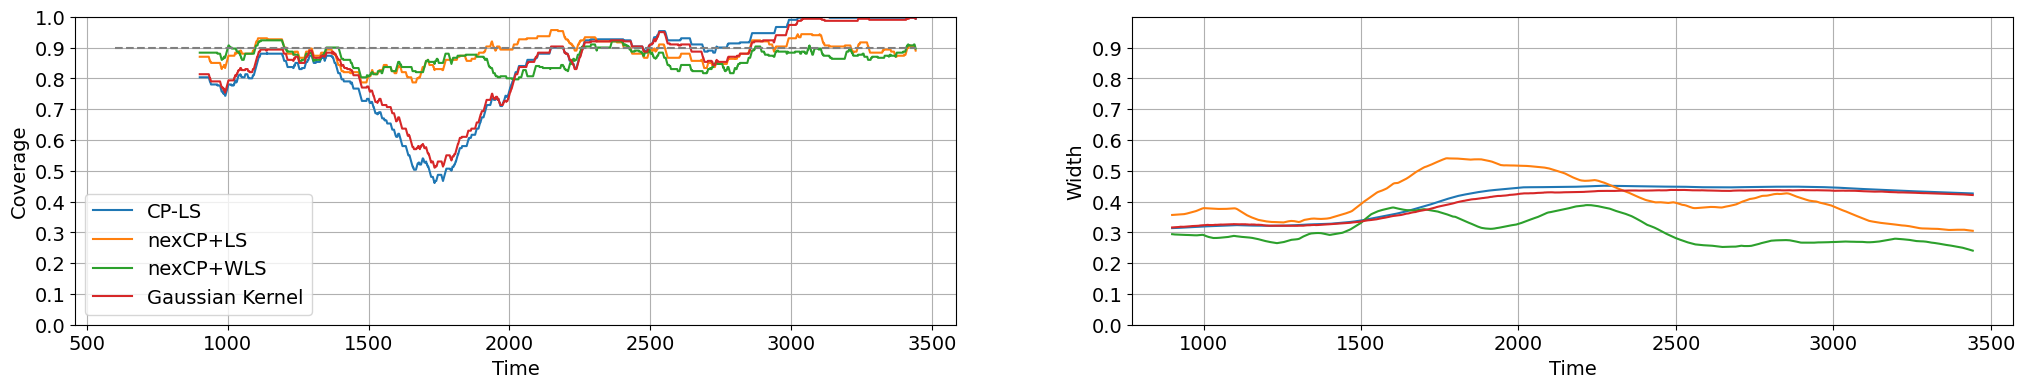

In [112]:
plt.rcParams.update({'font.size': 14})

window = 300 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x, np.ones(window)/window)[(window-1):-window]
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,4))

for method_idx, method in enumerate(methods):
    ax[0].plot(np.arange(train_lag+window,N), rolling_avg(coverage[method_idx], window))
    ax[1].plot(np.arange(train_lag + window, N), rolling_avg(pi_width[method_idx], window))

ax[0].hlines(1-alpha, xmin=train_lag, xmax=N, linestyles='--', colors='gray')
ax[0].legend(['CP-LS','nexCP+LS','nexCP+WLS', "Gaussian Kernel"])

ax[0].set_ylabel('Coverage')
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[0].set_xlabel('Time')
ax[0].grid(True)

ax[1].set_ylabel('Width')
ymax = np.max([
    pi_width[method_idx].max() for method_idx in range(len(methods))
]) * 1.1
ax[1].set_ylim([0, 1])
ax[1].set_yticks(np.arange(0, 1, 0.1))
ax[1].set_xlabel('Time')
ax[1].grid(True)

plt.show()

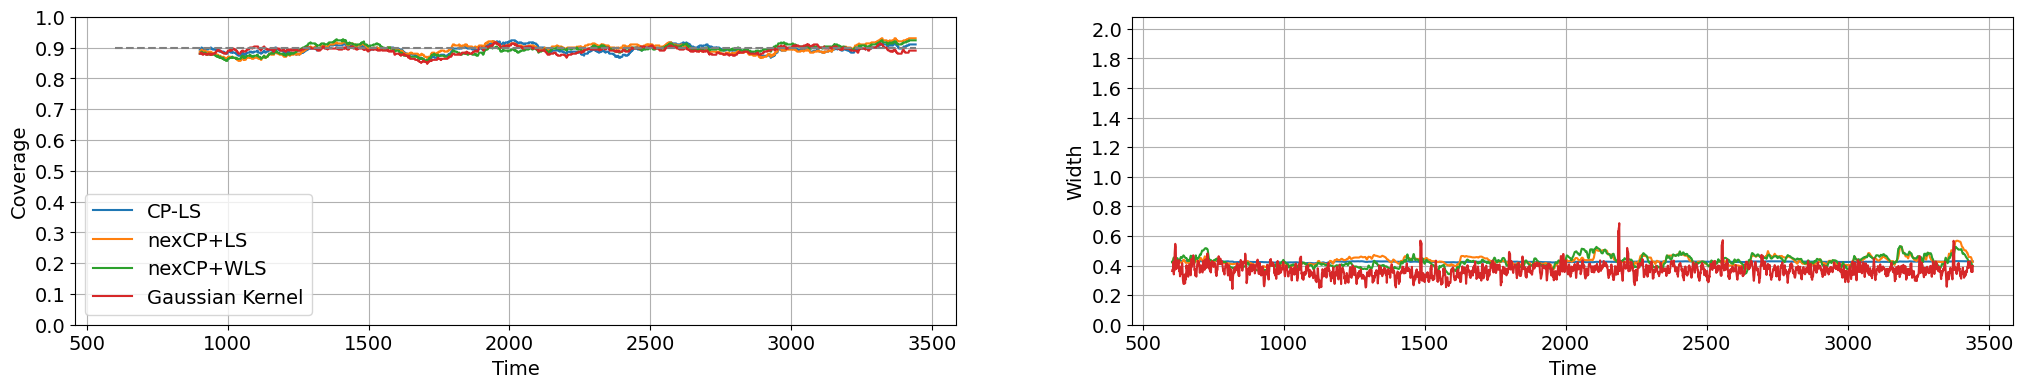

In [95]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,4))

for method_idx, method in enumerate(methods):
    ax[0].plot(np.arange(train_lag+window,N), rolling_avg(coverage_perm[method_idx], window))
    ax[1].plot(np.arange(train_lag + 5, N), rolling_avg(pi_width_perm[method_idx], 5))
    
ax[0].hlines(1-alpha, xmin=train_lag, xmax=N, linestyles='--', colors='gray')
ax[0].legend(['CP-LS','nexCP+LS','nexCP+WLS', "Gaussian Kernel"])

ax[0].set_ylabel('Coverage')
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax[0].set_xlabel('Time')
ax[0].grid(True)

ax[1].set_ylabel('Width')
ymax = np.max([
    pi_width_perm[method_idx].max() for method_idx in range(len(methods))
]) * 1.1
ax[1].set_ylim([0, ymax])
ax[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2])
ax[1].set_xlabel('Time')
ax[1].grid(True)

plt.show()

In [113]:
for method_idx, method in enumerate(methods):
    print(f'{method} coverage:|{np.mean(coverage[method_idx])}')
    print(f'{method} average prediction interval width: {np.mean(pi_width[method_idx])}')
    print("-"*90)

CP+LS coverage:|0.8491561181434599
CP+LS average prediction interval width: 0.4020399623533709
------------------------------------------------------------------------------------------
nexCP+LS coverage:|0.8825597749648383
nexCP+LS average prediction interval width: 0.39806109987724403
------------------------------------------------------------------------------------------
nexCP+WLS coverage:|0.8660337552742616
nexCP+WLS average prediction interval width: 0.29920093136951015
------------------------------------------------------------------------------------------
gaussian coverage:|0.8544303797468354
gaussian average prediction interval width: 0.3937505878690592
------------------------------------------------------------------------------------------


In [96]:
print("Randomly permuted data")
print("-"*90)
print("-"*90)
for method_idx, method in enumerate(methods):
    print(f'{method} coverage: {np.mean(coverage_perm[method_idx])}')
    print(f'{method} average prediction interval width: {np.mean(pi_width_perm[method_idx])}')
    print("-"*50)

Randomly permuted data
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
CP+LS coverage: 0.8948663853727145
CP+LS average prediction interval width: 0.42543455261316127
--------------------------------------------------
nexCP+LS coverage: 0.8976793248945147
nexCP+LS average prediction interval width: 0.434660488576452
--------------------------------------------------
nexCP+WLS coverage: 0.8959212376933896
nexCP+WLS average prediction interval width: 0.4285024165039788
--------------------------------------------------
gaussian coverage: 0.8895921237693389
gaussian average prediction interval width: 0.3667437986885192
--------------------------------------------------


In [ ]:
import pandas as pd
import pyperclip
# Create a dictionary with the results
results_dict = {
    'Method': methods,
    'Coverage': [np.mean(coverage_perm[method_idx]) for method_idx in range(len(methods))],
    'Average Prediction Interval Width': [np.mean(pi_width_perm[method_idx]) for method_idx in range(len(methods))]
}

# Create a dataframe from the dictionary
results_df = pd.DataFrame(results_dict)

# Copy the dataframe into a LaTeX table
latex_table = results_df.to_latex(index=False)

# Copy the LaTeX table to the clipboard
pyperclip.copy(latex_table)
